In [39]:
import pandas as pd
from imblearn.over_sampling import SMOTENC

# 加载数据并预处理
df = pd.read_csv('output4.csv')
top_10_cities = df["city"].value_counts().head(10).index
df['city'] = df['city'].where(df['city'].isin(top_10_cities), '其他')
df = df.drop(['job', 'company'], axis=1)

# 定义目标变量 y 和特征 X
y = df['city']
X = df.drop('city', axis=1)

# 定义分类特征列名（排除数值型列）
categorical_features = [
    'education', 'financing', 'insurance', 'bonus', 
    'examination', 'weekend', 'prospect', 'team', 
    'travel', 'train'
]

# 获取分类特征在 X 中的索引位置
categorical_indices = [X.columns.get_loc(col) for col in categorical_features]

# 初始化 SMOTE-NC，明确指定分类特征索引
smote_nc = SMOTENC(
    categorical_features=categorical_indices, 
    random_state=42
)

# 应用过采样
X_res, y_res = smote_nc.fit_resample(X, y)

print(X_res)
print(y_res)

       min_salary    max_salary education financing insurance bonus  \
0     6000.000000   8000.000000        不限     不需要融资         Y     Y   
1    10000.000000  18000.000000        本科     不需要融资         N     N   
2    15000.000000  30000.000000        本科     不需要融资         Y     Y   
3    15000.000000  25000.000000        本科        未知         N     N   
4    18000.000000  35000.000000        本科     不需要融资         Y     N   
..            ...           ...       ...       ...       ...   ...   
897   5139.675813   9367.610975        本科       未融资         Y     N   
898   5000.000000   6854.215577        本科     不需要融资         Y     N   
899   5909.926170  10909.926170        本科     不需要融资         N     N   
900  10278.538833  15417.808250        本科     不需要融资         N     N   
901  10034.760653  15048.664914        本科     不需要融资         N     N   

    examination weekend prospect team travel train  min_experience  \
0             N       N        N    N      N     N               0   
1      

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 确保 X_res 和 y_res 是 DataFrame/Series（SMOTE-NC 返回的是 numpy 数组）
X_res = pd.DataFrame(X_res, columns=X.columns)  # 恢复列名
y_res = pd.Series(y_res, name='city')           # 恢复目标列名


# 初始化标签编码器
le = LabelEncoder()

# 创建一个新的 DataFrame 用于存储编码后的特征
X_res_encoded = X_res.copy()

# 对每个特征列进行标签编码
for col in X_res.columns:
    # 只对非数值型列进行编码
    if X_res[col].dtype == 'object':
        X_res_encoded[col] = le.fit_transform(X_res[col])


# 划分训练集和测试集（分层抽样，保持类别分布）
X_train, X_test, y_train, y_test = train_test_split(
    X_res_encoded, 
    y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

print("训练集样本数:", len(X_train))
print("测试集样本数:", len(X_test))
print("类别分布（训练集）:\n", y_train.value_counts(normalize=True))
print("类别分布（测试集）:\n", y_test.value_counts(normalize=True))

训练集样本数: 721
测试集样本数: 181
类别分布（训练集）:
 city
重庆    0.091540
西安    0.091540
北京    0.091540
上海    0.091540
其他    0.091540
成都    0.091540
广州    0.090153
深圳    0.090153
南京    0.090153
武汉    0.090153
杭州    0.090153
Name: proportion, dtype: float64
类别分布（测试集）:
 city
南京    0.093923
杭州    0.093923
深圳    0.093923
广州    0.093923
武汉    0.093923
其他    0.088398
上海    0.088398
北京    0.088398
重庆    0.088398
成都    0.088398
西安    0.088398
Name: proportion, dtype: float64


最佳参数组合： {'n_neighbors': 4}
              precision    recall  f1-score   support

          上海       0.18      0.31      0.23        16
          其他       0.33      0.25      0.29        16
          北京       0.22      0.31      0.26        16
          南京       0.38      0.53      0.44        17
          广州       0.46      0.35      0.40        17
          成都       0.36      0.31      0.33        16
          杭州       0.42      0.29      0.34        17
          武汉       0.60      0.53      0.56        17
          深圳       0.40      0.35      0.38        17
          西安       0.56      0.56      0.56        16
          重庆       0.67      0.38      0.48        16

    accuracy                           0.38       181
   macro avg       0.42      0.38      0.39       181
weighted avg       0.42      0.38      0.39       181



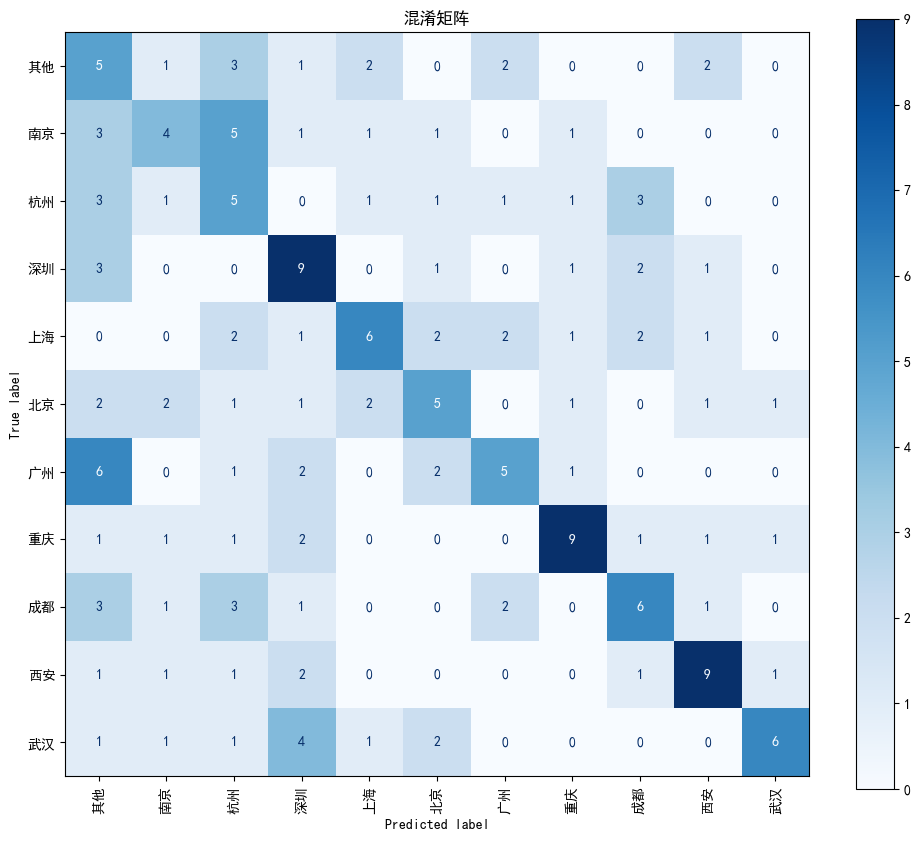

In [41]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

rf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(3, 50)
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("最佳参数组合：", grid_search.best_params_)


# 使用最佳模型对测试集进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=y_test.unique(),
    cmap='Blues',
    ax=ax,
    xticks_rotation='vertical'
)
plt.title(f'混淆矩阵')
plt.show()


最佳参数组合： {'max_depth': 20, 'n_estimators': 200}
              precision    recall  f1-score   support

          上海       0.30      0.44      0.36        16
          其他       0.50      0.25      0.33        16
          北京       0.44      0.44      0.44        16
          南京       0.48      0.59      0.53        17
          广州       0.53      0.47      0.50        17
          成都       0.57      0.81      0.67        16
          杭州       0.86      0.71      0.77        17
          武汉       0.92      0.71      0.80        17
          深圳       0.50      0.59      0.54        17
          西安       0.75      0.56      0.64        16
          重庆       0.81      0.81      0.81        16

    accuracy                           0.58       181
   macro avg       0.61      0.58      0.58       181
weighted avg       0.61      0.58      0.58       181



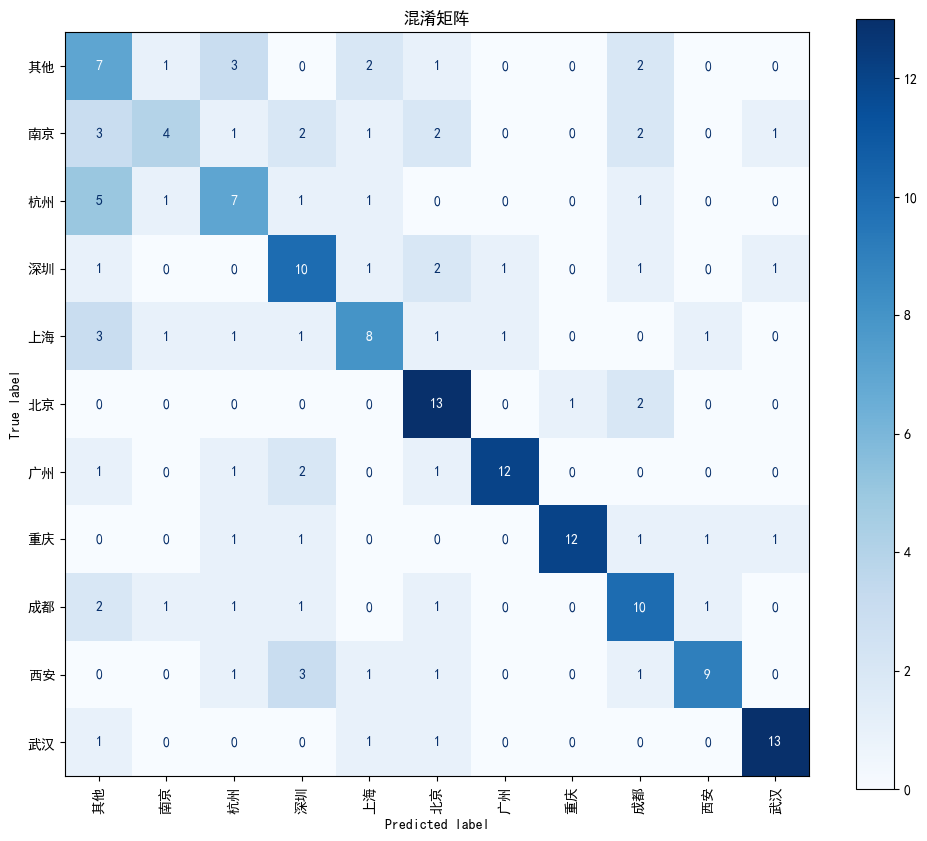

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier() 

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],  # 决策树的数量
    'max_depth': [None, 5, 10, 15, 20],  # 树的最大深度
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("最佳参数组合：", grid_search.best_params_)


# 使用最佳模型对测试集进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=y_test.unique(),
    cmap='Blues',
    ax=ax,
    xticks_rotation='vertical'
)
plt.title(f'混淆矩阵')
plt.show()


最佳参数组合： {'hidden_layer_sizes': (16, 16, 16), 'learning_rate_init': 0.01}
              precision    recall  f1-score   support

          上海       0.00      0.00      0.00        16
          其他       0.00      0.00      0.00        16
          北京       0.00      0.00      0.00        16
          南京       0.00      0.00      0.00        17
          广州       0.00      0.00      0.00        17
          成都       0.00      0.00      0.00        16
          杭州       0.00      0.00      0.00        17
          武汉       0.00      0.00      0.00        17
          深圳       0.00      0.00      0.00        17
          西安       0.20      0.56      0.30        16
          重庆       0.12      1.00      0.21        16

    accuracy                           0.14       181
   macro avg       0.03      0.14      0.05       181
weighted avg       0.03      0.14      0.05       181



c:\Users\Rex\miniconda3\envs\meisai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rex\miniconda3\envs\meisai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rex\miniconda3\envs\meisai\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


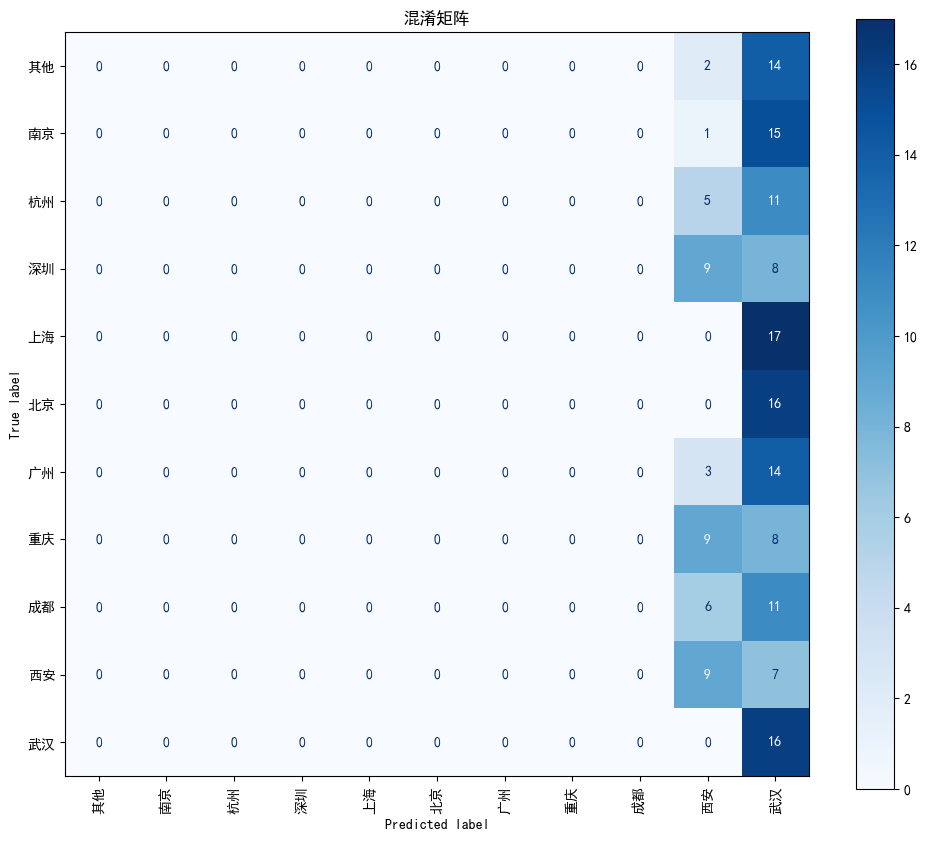

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


rf = MLPClassifier(max_iter=2500)

param_grid = {
    'hidden_layer_sizes': [(16, 16, 16), (8, 16, 8), (8, 8, 8)],  # 隐藏层的神经元数量和结构
    'learning_rate_init': [0.001, 0.01]  # 初始学习率
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("最佳参数组合：", grid_search.best_params_)


# 使用最佳模型对测试集进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=y_test.unique(),
    cmap='Blues',
    ax=ax,
    xticks_rotation='vertical'
)
plt.title(f'混淆矩阵')
plt.show()

最佳参数组合： {'C': 1000}
              precision    recall  f1-score   support

          上海       0.27      0.25      0.26        16
          其他       0.33      0.12      0.18        16
          北京       0.29      0.38      0.32        16
          南京       0.80      0.24      0.36        17
          广州       0.00      0.00      0.00        17
          成都       0.22      0.69      0.33        16
          杭州       0.28      0.41      0.33        17
          武汉       0.78      0.41      0.54        17
          深圳       0.38      0.18      0.24        17
          西安       0.53      0.56      0.55        16
          重庆       0.32      0.44      0.37        16

    accuracy                           0.33       181
   macro avg       0.38      0.33      0.32       181
weighted avg       0.38      0.33      0.32       181



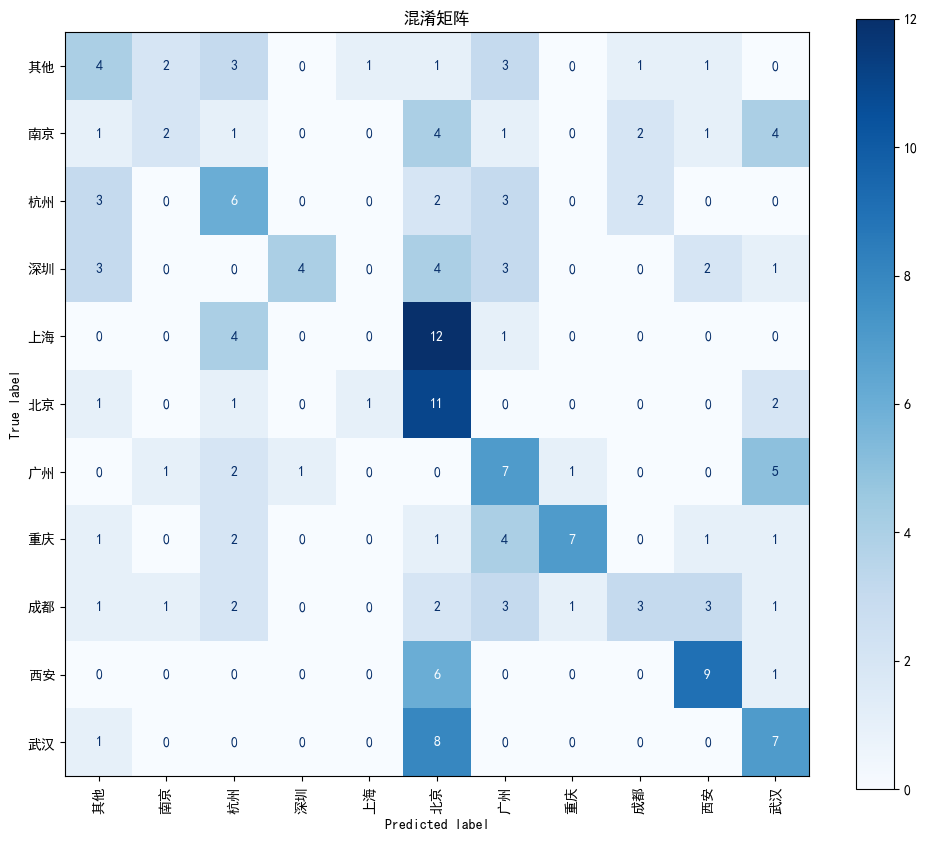

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


rf = SVC() 

param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("最佳参数组合：", grid_search.best_params_)


# 使用最佳模型对测试集进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=y_test.unique(),
    cmap='Blues',
    ax=ax,
    xticks_rotation='vertical'
)
plt.title(f'混淆矩阵')
plt.show()